<font size="6">**Halo Two-Point Correlation Function**</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import hmf
import halomod
from halomod import TracerHaloModel
from halotools.mock_observables import tpcf
import pickle
import os

print(f"Using halomod v{halomod.__version__} and hmf v{hmf.__version__}")

Using halomod v2.2.2 and hmf v3.5.1


In [18]:
plt.rcParams['font.family'] =['Times New Roman']

In [2]:
print("Loading data from previous notebooks...")

# Check if required files exist
required_files = ["group_ids.npy", "group_size_distribution.npy"]
missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print(f"⚠ Missing required files: {missing_files}")
    print("Please run Notebooks 1 and 2 first to generate the required data files.")
else:
    print("All required files found")

# Load data from previous notebooks
try:
    group_size_distribution = np.load("group_size_distribution.npy", allow_pickle=True).item()
    group_ids = np.load("group_ids.npy")
    print(f"Loaded group data: {len(group_size_distribution)} groups")
    print(f"Loaded group IDs: {len(group_ids)} particles")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please run Notebook 1 first to generate the required data files.")

Loading data from previous notebooks...
All required files found
Loaded group data: 25716544 groups
Loaded group IDs: 30687185 particles


In [3]:
file_path = '/Users/portia/Documents/Research/Cosmology/Halo/Particle_snap/snap_xyz.h5'

# Parameters from previous notebooks
particle_mass = 3.2e8  
Lbox = 50.0


In [ ]:
def create_theory_prediction(z=0, transfer_model="EH", hod_model="Zehavi05"):
    """Create theoretical halo two-point correlation function prediction"""
    
    print("Computing theoretical prediction...")
    
    hm = TracerHaloModel(
        z=z,  # redshift
        transfer_model=transfer_model,  # transfer function
        hod_model=hod_model,  # HOD model
        hod_params={
            "M_min": 12.5,
            "M_1": 13.5,
            "alpha": 1.0
        }
    )
    
    print(f"Theoretical model created successfully")
    print(f"   Redshift: {z}")
    print(f"   Transfer model: {transfer_model}")
    print(f"   HOD model: {hod_model}")
    
    return hm.r, hm.corr_auto_tracer, hm.corr_1h_auto_tracer, hm.corr_2h_auto_tracer

In [5]:
# Create initial theoretical prediction
r_theory, xi_theory, xi_1h, xi_2h = create_theory_prediction()

Computing theoretical prediction...
Theoretical model created successfully
  - Redshift: 0
  - Transfer model: EH
  - HOD model: Zehavi05


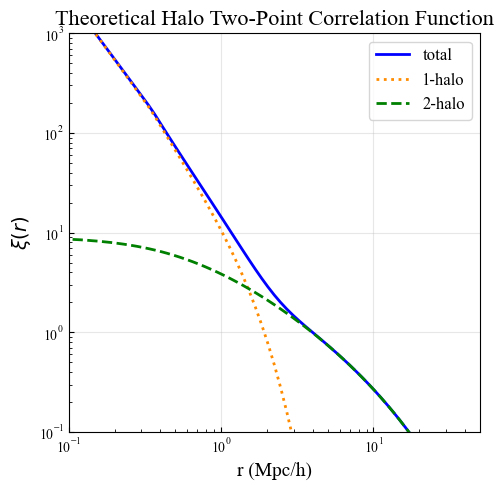


Theoretical predictions at r ≈ 2.0 Mpc/h:
  r = 2.03 Mpc/h
  1-halo term: 0.770
  2-halo term: 2.089
  total correlation function: 2.860


In [19]:
plt.figure(figsize=(5, 5))
plt.plot(r_theory, xi_theory, ls="-", label="total", linewidth=2, color='blue')
plt.plot(r_theory, xi_1h, ls=":", label="1-halo", linewidth=2, color='darkorange')
plt.plot(r_theory, xi_2h, ls="--", label="2-halo", linewidth=2, color='green')

plt.xscale("log")
plt.yscale("log")
plt.xlim(0.1, 50)
plt.ylim(0.1, 1000)
plt.tick_params(axis='x', direction='in', which='both') 
plt.tick_params(axis='y', direction='in', which='both')
plt.legend(fontsize=12)
plt.ylabel(r"$\xi(r)$", fontsize=14)
plt.xlabel(r"r (Mpc/h)", fontsize=14)
plt.title("Theoretical Halo Two-Point Correlation Function", fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print key information at specific scale
print(f"\nTheoretical predictions at r ≈ 2.0 Mpc/h:")
idx = (r_theory > 1.9) & (r_theory < 2.1)
if idx.any():
    r_val = r_theory[idx][0]
    xi_1h_val = xi_1h[idx][0]
    xi_2h_val = xi_2h[idx][0]
    xi_total_val = xi_theory[idx][0]
    print(f"  r = {r_val:.2f} Mpc/h")
    print(f"  1-halo term: {xi_1h_val:.3f}")
    print(f"  2-halo term: {xi_2h_val:.3f}")
    print(f"  total correlation function: {xi_total_val:.3f}")

In [11]:
def extract_halo_centers_from_simulation(min_particles=20):
    """Extract halo center coordinates from simulation data"""
    
    print(f"Extracting halo centers with >= {min_particles} particles...")
    
    # Load coordinate data
    try:
        with h5py.File(file_path, "r") as file:
            x = file['x_coords'][:]
            y = file['y_coords'][:]
            z = file['z_coords'][:]
        coordinates = np.vstack((x, y, z)).T
        print(f" Loaded coordinates: {coordinates.shape}")
    except FileNotFoundError:
        print(f" Cannot find coordinate file: {file_path}")
        print("Please update the file_path variable to match your data location.")
        return None, None, None
    
    # Filter halos with >= min_particles
    large_groups = {group_id: count for group_id, count in group_size_distribution.items() 
                   if count >= min_particles}
    
    # Calculate center and mass for each large halo
    halo_centers = []
    halo_masses = []
    halo_particle_counts = []
    
    print(f"Processing {len(large_groups)} halos with >= {min_particles} particles...")
    
    for group_id, particle_count in large_groups.items():
        # Find all particles belonging to this halo
        particle_indices = np.where(group_ids == group_id)[0]
        halo_coords = coordinates[particle_indices]
        
        # Calculate halo center (mean position)
        center = np.mean(halo_coords, axis=0)
        mass = particle_count * particle_mass
        
        halo_centers.append(center)
        halo_masses.append(mass)
        halo_particle_counts.append(particle_count)
    
    halo_centers = np.array(halo_centers)
    halo_masses = np.array(halo_masses)
    halo_particle_counts = np.array(halo_particle_counts)
    
    print(f"  Extracted {len(halo_centers)} halo centers")
    print(f"  Mass range: {np.min(halo_masses):.2e} - {np.max(halo_masses):.2e} h^-1 M_sun")
    print(f"  Particle count range: {np.min(halo_particle_counts)} - {np.max(halo_particle_counts)}")
    
    return halo_centers, halo_masses, halo_particle_counts

In [12]:
def create_adaptive_rbins(Lbox=50.0, n_bins_total=25):
    """Create adaptive rbins distribution for better sampling"""
    
    max_distance = Lbox / 3.5  # Maximum meaningful separation
    r_points = []
    
    # Small scale: 0.1-1 Mpc, dense sampling (high clustering)
    n_small = int(n_bins_total * 0.48)  # ~12 points
    r_points.extend(np.logspace(-1, 0, n_small))
    
    # Medium scale: 1-5 Mpc, medium sampling 
    n_medium = int(n_bins_total * 0.36)  # ~9 points
    r_points.extend(np.logspace(0, np.log10(5), n_medium + 1)[1:])
    
    # Large scale: 5-max Mpc, sparse sampling (low clustering)
    n_large = n_bins_total - len(r_points)  # remaining points
    r_points.extend(np.logspace(np.log10(5), np.log10(max_distance), n_large + 1)[1:])
    
    return np.array(r_points)

In [13]:
def calculate_halo_correlation_function(halo_centers, Lbox=50.0, n_bins=25):
    """Calculate halo 2PCF from simulation data"""
    
    rbins = create_adaptive_rbins(Lbox, n_bins)
    
    print(f"Calculating correlation function...")
    print(f"  Using adaptive binning strategy: {len(rbins)} bins")
    print(f"  Radial range: {rbins[0]:.2f} - {rbins[-1]:.2f} Mpc/h")
    print(f"  Number of halos: {len(halo_centers)}")
    
    # Calculate 2PCF using halotools
    try:
        xi_sim = tpcf(
            sample1=halo_centers,
            rbins=rbins,
            period=Lbox,
            estimator='Natural',
            num_threads=4
        )
    except TypeError:
        print("  Parameter adjustment, using simplified version...")
        xi_sim = tpcf(
            sample1=halo_centers,
            rbins=rbins,
            period=Lbox,
            estimator='Natural'
        )
    
    # Calculate bin centers
    rbin_centers = np.sqrt(rbins[:-1] * rbins[1:])
    
    print(f"Correlation function calculation completed")
    print(f"Data points: {len(rbin_centers)}")
    
    return rbin_centers, xi_sim

In [17]:
print("Computing halo 2pcf data:\n")

try:
    # 1. Extract halo data from simulation
    halo_centers, halo_masses, halo_counts = extract_halo_centers_from_simulation(min_particles=20)
    
    if halo_centers is not None:
        # 2. Calculate simulation correlation function
        r_sim, xi_sim = calculate_halo_correlation_function(halo_centers, Lbox=Lbox)
        
        # 3. Organize all data
        correlation_data = {
            'r_sim': r_sim,
            'xi_sim': xi_sim,
            'r_theory': r_theory,
            'xi_theory': xi_theory,
            'xi_1h': xi_1h,
            'xi_2h': xi_2h,
            'halo_centers': halo_centers,
            'halo_masses': halo_masses,
            'halo_counts': halo_counts,
            'Lbox': Lbox,
            'particle_mass': particle_mass
        }


        print("\n" + "="*50)
        print("\n")
        print("Data computation completed:\n")
        print(f"Simulation data points: {len(r_sim)}")
        print(f"Theory data points: {len(r_theory)}")
        print(f"Total number of halos: {len(halo_centers)}")
        print(f"Data stored in variable 'correlation_data'")
        
    else:
        print("Failed to extract halo centers. Check file path and data.")
        
except Exception as e:
    print(f"Error occurred during computation: {e}")
    import traceback
    traceback.print_exc()

Computing halo 2pcf data:

Extracting halo centers with >= 20 particles...
 Loaded coordinates: (30687185, 3)
Processing 17645 halos with >= 20 particles...
  Extracted 17645 halo centers
  Mass range: 6.40e+09 - 2.31e+13 h^-1 M_sun
  Particle count range: 20 - 72212
Calculating correlation function...
  Using adaptive binning strategy: 25 bins
  Radial range: 0.10 - 14.29 Mpc/h
  Number of halos: 17645
Correlation function calculation completed
Data points: 24



Data computation completed:

Simulation data points: 24
Theory data points: 100
Total number of halos: 17645
Data stored in variable 'correlation_data'


In [22]:
def plot_correlation_function(data, 
                            figsize=(8, 6),
                            title="Halo Two-Point Correlation Function",
                            xlabel=r"r (Mpc/h)",
                            ylabel=r"$\xi(r)$",
                            xlim=(0.1, 20),
                            ylim=(0.01, 1000),
                            save_name=None):
    """
    Create publication-quality plot of halo correlation function
    """
    
    # Extract data
    r_sim, xi_sim = data['r_sim'], data['xi_sim']
    r_theory, xi_theory = data['r_theory'], data['xi_theory']
    xi_1h, xi_2h = data['xi_1h'], data['xi_2h']
    
    plt.figure(figsize=figsize)
    
    # Plot theory curves
    plt.plot(r_theory, xi_theory, 
            linestyle='-', linewidth=2.5, color='blue', 
            alpha=0.9, label='Total (Theory)')
    
    plt.plot(r_theory, xi_1h, 
            linestyle=':', linewidth=2, color='darkorange',
            alpha=0.8, label='1-halo (Theory)')
    
    plt.plot(r_theory, xi_2h, 
            linestyle='--', linewidth=2, color='green',
            alpha=0.8, label='2-halo (Theory)')
    
    # Plot simulation data points
    valid_mask = xi_sim > 0
    if np.any(valid_mask):
        plt.scatter(r_sim[valid_mask], xi_sim[valid_mask],
                   s=50, marker='o', facecolors='white', 
                   edgecolors='red', linewidths=2, 
                   alpha=1.0, zorder=5, label='Simulation Data')
    
    # Formatting
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.tick_params(axis='both', direction='in', which='both', labelsize=12)
    plt.legend(fontsize=12, loc='upper right', frameon=True)
    plt.grid(False)
    plt.tight_layout()


Correlation function values at key scales:
r [Mpc/h]  ξ_sim        ξ_theory     ξ_1h         ξ_2h        
------------------------------------------------------------
1.09       11.924       13.024       9.292        3.732       
1.87       3.797        2.860        0.770        2.089       
4.57       0.771        0.794        0.001        0.792       
9.64       0.343        0.260        0.000        0.260       


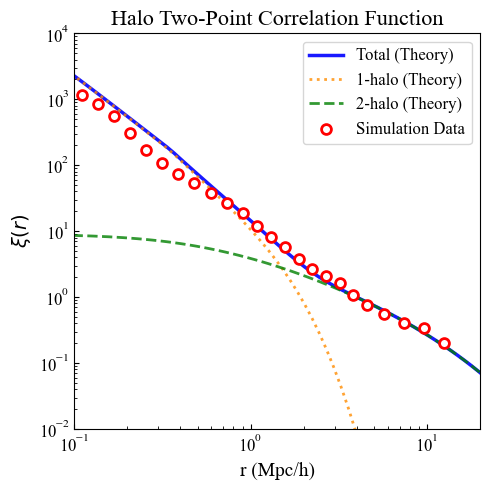

In [23]:
if 'correlation_data' in locals():
    
    plot_correlation_function(
        correlation_data,
        figsize=(5, 5),
        title="Halo Two-Point Correlation Function",
        xlim=(0.1, 20),
        ylim=(0.01, 10000),
        save_name="halo_correlation_function.png"
    )
    
    # Print some statistics
    # print("\nCorrelation Function Statistics:")
    # print("-" * 40)
    
    # Find overlapping range for comparison
    r_min_common = max(np.min(correlation_data['r_sim']), np.min(correlation_data['r_theory']))
    r_max_common = min(np.max(correlation_data['r_sim']), np.max(correlation_data['r_theory']))
    
    # print(f"Simulation r range: {np.min(correlation_data['r_sim']):.2f} - {np.max(correlation_data['r_sim']):.2f} Mpc/h")
    # print(f"Theory r range: {np.min(correlation_data['r_theory']):.2f} - {np.max(correlation_data['r_theory']):.2f} Mpc/h")
    # print(f"Common range: {r_min_common:.2f} - {r_max_common:.2f} Mpc/h")
    
    # Print values at specific scales
    scales_of_interest = [1.0, 2.0, 5.0, 10.0]
    print(f"\nCorrelation function values at key scales:")
    print(f"{'r [Mpc/h]':<10} {'ξ_sim':<12} {'ξ_theory':<12} {'ξ_1h':<12} {'ξ_2h':<12}")
    print("-" * 60)
    
    for r_target in scales_of_interest:
        # Find closest simulation point
        idx_sim = np.argmin(np.abs(correlation_data['r_sim'] - r_target))
        r_sim_closest = correlation_data['r_sim'][idx_sim]
        xi_sim_val = correlation_data['xi_sim'][idx_sim]
        
        # Find closest theory point
        idx_theory = np.argmin(np.abs(correlation_data['r_theory'] - r_target))
        r_theory_closest = correlation_data['r_theory'][idx_theory]
        xi_theory_val = correlation_data['xi_theory'][idx_theory]
        xi_1h_val = correlation_data['xi_1h'][idx_theory]
        xi_2h_val = correlation_data['xi_2h'][idx_theory]
        
        if abs(r_sim_closest - r_target) < 0.5:  # Only print if reasonably close
            print(f"{r_sim_closest:<10.2f} {xi_sim_val:<12.3f} {xi_theory_val:<12.3f} {xi_1h_val:<12.3f} {xi_2h_val:<12.3f}")